In [1]:
!pip install flask
!pip install pyserial
!pip install opencv-python
!pip install nbimporter
!pip install torch torchaudio torchvision
!jupyter nbconvert --to script text_processing.ipynb
!jupyter nbconvert --to script camera_operation.ipynb
!jupyter nbconvert --to script braille_translate.ipynb

[NbConvertApp] Converting notebook text_processing.ipynb to script
[NbConvertApp] Writing 3739 bytes to text_processing.py
[NbConvertApp] Converting notebook camera_operation.ipynb to script
[NbConvertApp] Writing 675 bytes to camera_operation.py
[NbConvertApp] Converting notebook braille_translate.ipynb to script
[NbConvertApp] Writing 6609 bytes to braille_translate.py


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Jun/2024 14:24:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:24:59] "GET /video?rand=0.10390606125124324 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:24:59] "GET /video?rand=0.555255676202377 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.5512661694369976 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.8113571829344066 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.5386949532204837 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.6898127442395692 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.1032530670940155 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /video?rand=0.17104555048308812 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:00] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1

===============  Received from Arduino ->  Take Picture   ===============
< 1 - 이미지 촬영 >
1-1 이미지 촬영 진행 중입니다.
1-2 이미지 촬영이 완료되었습니다.
이미지 경로 : C:\Users\peter\capstone\camera\20240603-142514.jpg

< 2 - 텍스트 인식 >
2-1 이미지 내 텍스트 인식을 진행 중입니다.


Using CPU. Note: This module is much faster with a GPU.
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /video?rand=0.6165773855514629 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /video?rand=0.6483415880114243 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /video?rand=0.3386759873030405 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /video?rand=0.037626979369381974 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:25:15] "GET /current_status HTTP/1.1" 200 -
[2024-06-03 14:25:15,409] ERROR in app: Exception on /labelled_image [GET]
Traceback (most recent call last):
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\s

2-2 이미지 내 텍스트 인식을 완료했습니다.


127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /video?rand=0.3406942552390271 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /video?rand=0.06859714281381679 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:49] "GET /current_status HTTP/1.1" 200 -
[2024-06-03 14:27:50,779] ERROR in app: Exception on /labelled_image [GET]
Traceback (most recent call last):
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_us

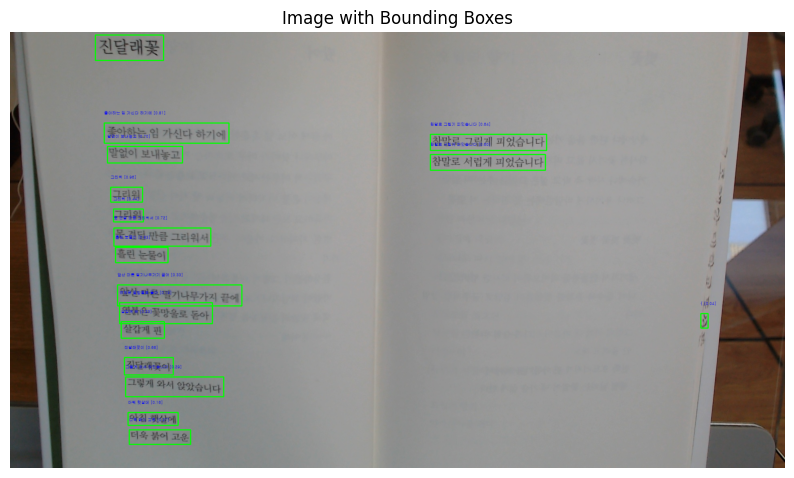

2-3 이미지 내 텍스트 라벨링 및 저장을 완료했습니다.
2-4 텍스트 철자 및 문법 교정을 진행 중입니다. 
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.


127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /current_status HTTP/1.1" 200 -


한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
2-5 철자 및 문법 교정을 완료했습니다.
인식된 텍스트 >>>  ['진달래꽃', '좋아하는', '임', '가신다', '하기에', '침말로', '그립기', '피있습니다', '말없이', '보내농고', '참말로', '서립게', '피있습니다', '그리위', '그리위', '못', '건달', '만큼', '그리위서', '흘린', '눈물이', '앞산', '마른', '덜기나무가기', '끝어', '연젠은', '꽃망울로', '돌아', '살갑계', '관', '진달래끗이', '그렇계', '와서', '앉있습니다', '아뭐', '햇살데', '디욱', '닭이', '고운']
< 3 - 텍스트 점자로 변환 >
텍스트를 점자로 변환 중입니다...
점자 변환이 완료됐습니다.
점자 텍스트 >>>  ['50742120027203015360', '50533643241156', '5223', '45037421', '24015254', '60522312200253', '01250252400152', '26525231032540115221', '122061233052', '0453117211770153', '60432312200253', '03610252400154', '26525231032540115221', '012502525172', '012502525172', '125330', '01672120', '1222622523', '0125025251720361', '36650274', '1144127552', '43267022', '120256', '216401521112514

127.0.0.1 - - [03/Jun/2024 14:27:52] "GET /video?rand=0.7066755263150821 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /video?rand=0.5239904441985985 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /video?rand=0.705104981844086 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /video?rand=0.46886709835080587 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:53] "GET /video?rand=0.6090145518217636 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:54] "GET /video?rand=0.30969373887935636 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:54] "GET /video?rand=0.8227175503225377 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:54] "GET /video?rand=0.6241464624724107 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:27:54] "GET /video?rand=

===============  Received from Arduino ->  Next   ===============
단어: 진달래꽃
점자: 50742120027203015360


127.0.0.1 - - [03/Jun/2024 14:28:03] "GET /video?rand=0.24066861204949608 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:03] "GET /video?rand=0.12172205552608273 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:03] "GET /video?rand=0.23254018153649603 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /video?rand=0.6497797921819732 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /video?rand=0.0678787886590222 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /video?rand=0.8989128252288465 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /video?rand=0.7331736445459613 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:04] "GET /video?rand=0.51283310302

===============  Received from Arduino ->  Next   ===============
단어: 좋아하는
점자: 50533643241156


127.0.0.1 - - [03/Jun/2024 14:28:12] "GET /video?rand=0.2955800833614448 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:12] "GET /video?rand=0.939735223722725 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.5383332012738147 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.8670063785799973 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.7232568175593657 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.9676956624783766 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.5823049375548253 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.6813034772692281 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:13] "GET /video?rand=0.

===============  Received from Arduino ->  Next   ===============
단어: 임
점자: 5223


127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.04151604293601108 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.09276278400714544 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.6774689780742391 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.5074128188212303 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.03398420113162515 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.2404679902137301 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.4192337237446042 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.03182267571984876 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:16] "GET /video?rand=0.15236897752097422 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:17] "GET /vi

===============  Received from Arduino ->  Next   ===============
단어: 가신다
점자: 45037421


127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.9340952731689911 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.6429736573875993 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.6326482194930056 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.4167079253848873 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.002466415974845093 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.10589986344081592 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:18] "GET /video?rand=0.2344345039419471 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:19] "GET /video?rand=0.2598802324359317 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:19] "GET /video?rand=0.8878994722785685 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:19] "GET /video?rand=0.015866833632418142 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:19] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun

===============  Received from Arduino ->  Next   ===============
단어: 하기에
점자: 24015254


127.0.0.1 - - [03/Jun/2024 14:28:19] "GET /video?rand=0.8390009822173712 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.09572772794398476 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.33864743680287557 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.7929071806353671 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.7833847202160094 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.7559407669855684 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.38436846966816973 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?rand=0.4694580863262774 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:20] "GET /video?ran

===============  Received from Arduino ->  Next   ===============
단어: 침말로
점자: 60522312200253


127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.32715941251735403 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.9734913261322429 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.16288262757912353 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.9594983035455105 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.20406233155154507 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.4342199185442297 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.5534099148208944 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:24] "GET /video?rand=0.09256314729

===============  Received from Arduino ->  Next   ===============
단어: 그립기
점자: 01250252400152


127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.24155601414235406 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.9269435674823765 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.6126497147129579 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.9780136997680065 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.4572293849292408 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.43410907706565105 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.6861550461234138 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.07024381379052169 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:26] "GET /video?rand=0.71925747696828 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:27] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:27] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:27] "G

===============  Received from Arduino ->  Next   ===============
단어: 피있습니다
점자: 26525231032540115221


127.0.0.1 - - [03/Jun/2024 14:28:29] "GET /video?rand=0.2470187307036389 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:29] "GET /video?rand=0.7802208712618106 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:29] "GET /video?rand=0.055690641867507384 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:29] "GET /video?rand=0.7692794860683356 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.6969649161948324 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.4891526753689104 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.23271142913978848 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.6287625908686565 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?ran

===============  Received from Arduino ->  Next   ===============
단어: 말없이
점자: 122061233052


127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.5617135821520367 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:30] "GET /video?rand=0.6253668114266291 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.4195988498372518 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.40928955548867285 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.9523539470402644 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.4369655795579841 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.7899508877525867 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand=0.29090868663921543 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:31] "GET /video?rand

===============  Received from Arduino ->  Next   ===============
단어: 보내농고
점자: 0453117211770153


127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.9046482600246195 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.32383060882830006 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.41934476707661084 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.9495793332662357 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.6379866875337843 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.2511873319913447 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.9366135657097758 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.05439682416292513 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:34] "GET /video?rand=0.047663441907854764 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:35] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:35] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2024 14:28:35

In [12]:
from flask import Flask, render_template, Response, request, jsonify
import serial
import time
import os
import cv2
import threading
import subprocess
import nbimporter
import io
from PIL import Image
from camera_operation import taking_picture
from text_processing import text_correction, text_detection
from braille_translate import text_to_braille

app = Flask(__name__)

# 연결할 시리얼 포트와 baudrate 설정
ser = serial.Serial('COM7', 9600)

# 변수 초기화
camera = cv2.VideoCapture(1)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1980) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
recognized_texts_global = [] # 인식된 텍스트 리스트
current_text_index = -1 # 리스트 위치 변수
braille_texts = []
labelled_img_path = None
word = ""
last_arduino_message = ""  # Arduino로부터 받은 마지막 메시지를 저장하는 변수
current_status_message = "" # 현재 진행상황

def read_from_port(ser):
    global recognized_texts_global, current_text_index, braille_texts, labelled_img_path, word, last_arduino_message, current_status_message
    
    while True:
        reading = ser.readline().decode().strip()
        
        print("===============  Received from Arduino -> ", reading, "  ===============")
        if reading == "Take Picture":
            # 메시지 업데이트
            last_arduino_message = "촬영 버튼"
            
            # 1 - 이미지 촬영
            print("< 1 - 이미지 촬영 >")
            img_path = taking_picture(camera)

            # 널값인지 검사
            if img_path is None:
                current_status_message = "[Error] 이미지 촬영에 실패했습니다. 카메라를 확인하시고 다시 촬영해주세요."
                continue
            else:
                current_status_message = "이미지 촬영이 완료됐습니다. 텍스트 인식을 진행합니다."
            
            # 2 - 텍스트 인식
            print("< 2 - 텍스트 인식 >")
            recognized_texts, labelled_img_path = text_detection(img_path)
                
            # 인식된 텍스트 처리
            words_list = [word for text in recognized_texts for word in text.split()]
            try:
                corrected_texts = text_correction(words_list)
            except ValueError as e:
                print(f"예외 발생: {e}")
                continue
            
            filtered_texts = [text for text in corrected_texts if text.strip()]
            #filtered_texts = [text for text in words_list if text.strip()]
            print("인식된 텍스트 >>> ", filtered_texts)
            recognized_texts_global = filtered_texts  # 새로운 텍스트로 업데이트
            current_text_index = -1  # 새로운 텍스트 리스트로 업데이트되면 인덱스 초기화
            current_status_message = "텍스트 인식이 완료됐습니다. " + ", ".join([text for text in recognized_texts_global])
            
            # 3 - 텍스트를 점자로 변환하여 저장
            print("< 3 - 텍스트 점자로 변환 >")
            braille_texts = text_to_braille(filtered_texts)
            print("점자 텍스트 >>> ", braille_texts)
            current_status_message = "점자 변환이 완료됐습니다. 다음 단어 출력 버튼과 이전 버튼 출력을 눌러 점자 확인이 가능합니다."
            
        elif reading == "Next":
            # 메시지 업데이트
            current_status_message = "다음 단어 출력 버튼이 입력됐습니다."
            last_arduino_message = "다음 단어 출력 버튼"
            next_text()
            
        elif reading == "Previous":
            # 메시지 업데이트
            current_status_message = "이전 단어 출력 버튼이 입력됐습니다."
            last_arduino_message = "이전 단어 출력 버튼"
            previous_text()

def next_text():
    global current_text_index, word, current_status_message
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index < len(recognized_texts_global) - 1:
        current_text_index += 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
    else:
        current_status_message = "인식된 텍스트를 다 읽었습니다."
        print("리스트의 끝점입니다.")

def previous_text():
    global current_text_index, word, current_status_message
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index > 0:
        current_text_index -= 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
        
    else:
        current_status_message = "첫 번째 텍스트이므로 그 이전 단어가 없습니다."
        print("리스트의 시작점입니다.")

def send_text_to_arduino(text, braille):
    print("단어:", text)
    print("점자:", braille)
    ser.write((braille + "\n").encode())

def generate_frames():
    while True:
        success, frame = camera.read()  # 카메라로부터 프레임 읽기
        if not success:
            break
        else:
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
            
@app.route('/')
def index():
    return render_template('final_index.html')

@app.route('/video')
def video():
    return Response(generate_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/labelled_image')
def labelled_image():
    img = cv2.imread(labelled_img_path)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_io = io.BytesIO()
    img_pil.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return Response(img_io.getvalue(), mimetype='image/jpeg')

@app.route('/arduino_received_message')
def arduino_received_message():
    # Arduino로부터 받은 마지막 메시지를 반환합니다.
    return jsonify({"message": last_arduino_message})

@app.route('/send_to_arduino')
def send_to_arduino():
    # Arduino로 보낸 문자열 반환
    return jsonify({"message": word})

@app.route('/current_status')
def get_current_status():
    # 현재 진행 상황을 출력
    return jsonify({"message": current_status_message})
    
if __name__ == '__main__':
    thread = threading.Thread(target=read_from_port, args=(ser,))
    thread.start()
    app.run(debug=False, host='0.0.0.0', port=5000) 